# 1. Ingestão e Armazenamento

## Configurando opção "Mostrar todas as colunas"

In [1]:
import pandas as pd

pd.set_option('display.max_columns', None) # Opção "Display.max_columns" configura o pandas a mostrar todas as colunas do DataFrame"

## Download DataSet

O DataSet Utilizado foi Titanic que faz parte de uma competição do Kaggle no seguinte link: https://www.kaggle.com/competitions/titanic/data

Dicionário de dados:

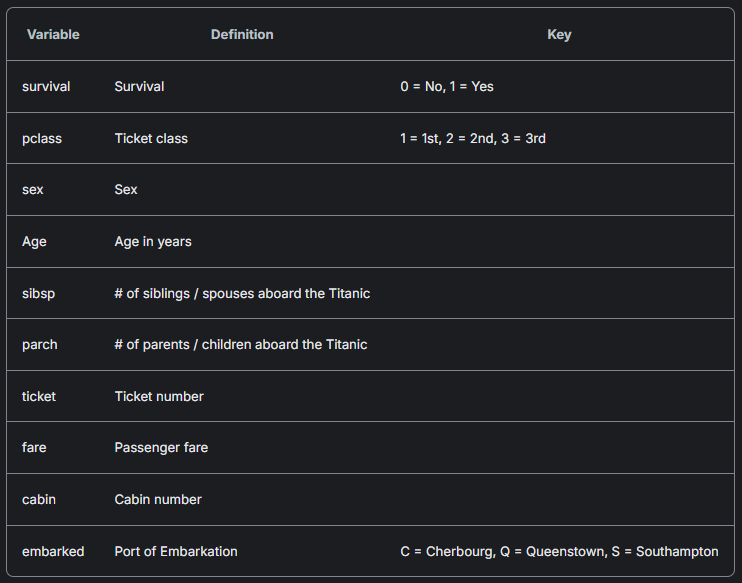

In [2]:
import os
from dotenv import load_dotenv
from kaggle.api.kaggle_api_extended import KaggleApi

# Carrega as variáveis do arquivo .env
load_dotenv()

# Define as variáveis de ambiente exigidas pela API do Kaggle:
os.environ['KAGGLE_USERNAME'] = os.getenv("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = os.getenv("KAGGLE_KEY")

# Inicializa e autentica a API:
api = KaggleApi()
api.authenticate()

In [3]:
#Download DataSet via API Kaggle
import zipfile

download_path = os.getcwd()

api.competition_download_files(
    competition='titanic',                  # nome do dataset no Kaggle
    path=download_path,                     # pasta local para salvar os arquivos                        # descompactar o conteúdo
)

zip_path = os.path.join(download_path, 'titanic.zip')

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(download_path)

## Download DuckDB

In [4]:
import duckdb

In [ ]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Carregando os dados em uma instância local

In [6]:
# Criando instância local:
con = duckdb.connect()

In [7]:
# Registrando o DataFrame como tabela no DuckDB:
con.register('titanic', df)

# 2. Exploração de dados (EDA)

## Número de linhas e colunas

In [8]:
def execute_query(query: 'str', con = con) -> pd.DataFrame:
    """
    Executa uma consulta SQL e retorna o resultado como um DataFrame.
    """
    return con.execute(query).fetchdf()

In [9]:
# Número de linhas:

execute_query(
    "SELECT COUNT(*) AS total_linhas FROM titanic"
)

,total_linhas
0,891


In [10]:
# Número de colunas:

execute_query(
    "SELECT COUNT(*) AS total_colunas FROM information_schema.columns WHERE table_name = 'titanic'"
)

,total_colunas
0,12


Conclusão:

891 linhas e 12 colunas

## Valores nulos

In [11]:
query_nulos = "SELECT " # Iniciando a string que será utilizada como consulta query de dados nulos

In [12]:
for i in list(df.columns): # Iteração com todas as colunas para formar a string query_nulos que contará dados nulos

    if i != list(df.columns)[-1]: # Se i não é a última coluna então...
      query_nulos += f"SUM({i} IS NULL) AS nulos_{i}, "

    else: # Se i for a última coluna então...
      query_nulos += f"SUM({i} IS NULL) AS nulos_{i} "

query_nulos = query_nulos[:-1] + " FROM 'titanic'"

In [13]:
query_nulos

"SELECT SUM(PassengerId IS NULL) AS nulos_PassengerId, SUM(Survived IS NULL) AS nulos_Survived, SUM(Pclass IS NULL) AS nulos_Pclass, SUM(Name IS NULL) AS nulos_Name, SUM(Sex IS NULL) AS nulos_Sex, SUM(Age IS NULL) AS nulos_Age, SUM(SibSp IS NULL) AS nulos_SibSp, SUM(Parch IS NULL) AS nulos_Parch, SUM(Ticket IS NULL) AS nulos_Ticket, SUM(Fare IS NULL) AS nulos_Fare, SUM(Cabin IS NULL) AS nulos_Cabin, SUM(Embarked IS NULL) AS nulos_Embarked FROM 'titanic'"

In [14]:
execute_query(query_nulos)

,nulos_PassengerId,nulos_Survived,nulos_Pclass,nulos_Name,nulos_Sex,nulos_Age,nulos_SibSp,nulos_Parch,nulos_Ticket,nulos_Fare,nulos_Cabin,nulos_Embarked
0,0.0,0.0,0.0,0.0,0.0,177.0,0.0,0.0,0.0,0.0,687.0,2.0


Conclusão:

Age - 177 nulos

Cabin - 687 nulos

Embarked - 2 nulos

In [15]:
for i in ['PassengerId', 'Name', 'Ticket']: # Removendo colunas: PassengerId, Name, Ticket
  df.drop(columns=[i], inplace=True)

## Correlação entre variáveis com DuckDB

In [16]:
query_corr = "SELECT " # Iniciando a string query_corr
numeric_cols = df.select_dtypes(include=['number']).columns.tolist() # Selecionando colunas numéricas

In [17]:
from itertools import combinations

pares = list(combinations(numeric_cols, 2)) # Criando pares de colunas numéricas

In [18]:
correlacoes = []

for x, y in pares: # Criando iteração na lista 'correlacoes'
  valor = execute_query(f'SELECT CORR({x}, {y}) AS corr FROM titanic')['corr'][0] # Executa a query 'SELECT CORR(coluna_1, coluna_2) AS corr...
  correlacoes.append((x, y, valor))

In [19]:
matriz = pd.DataFrame(index=numeric_cols, columns=numeric_cols) # Criando matriz de correlação

for x, y, val in correlacoes: # Preenchendo a matriz com os valores de correlações correspondentes
  matriz.loc[x, y] = val
  matriz.loc[y, x] = val

for col in matriz.columns: # Correlação perfeita entre a mesma variável
  matriz.loc[col, col] = 1.0

matriz = matriz.astype(float) # Configurando tipagem float para evitar quebra do código abaixo

<Axes: >

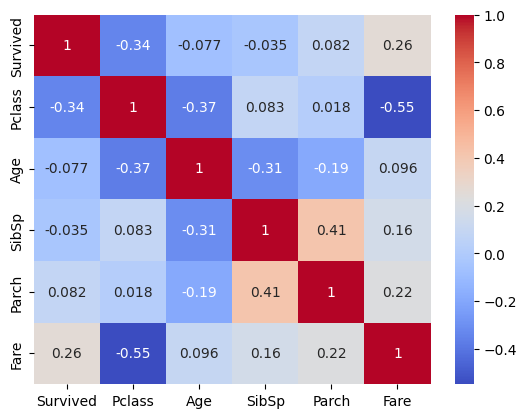

In [20]:
import seaborn as sns

sns.heatmap(matriz, annot=True, cmap='coolwarm')

In [21]:
con.close() # Fechando conexão com banco de dados no DuckDB

## Correlações com Python e Pandas

<Axes: >

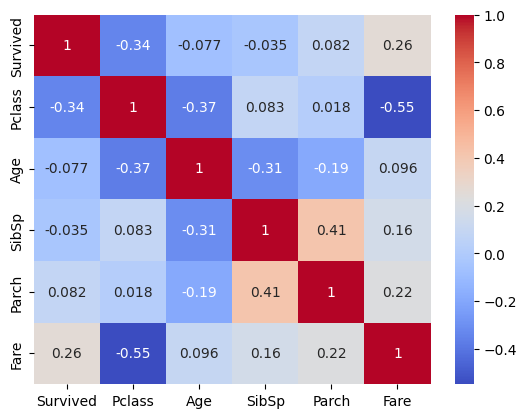

In [22]:
df_numeric = df.select_dtypes(include=['number']) # Selecionando colunas numéricas

correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# 3. Pré-processamento

## Tratando dados nulos

In [23]:
# DataFrame com número de dados nulos:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [24]:
# Porcentagem de dados nulos:
(df.isnull().sum() / len(df)) * 100

Survived     0.000000
Pclass       0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64

### Age

In [25]:
# Número de dados nulos por PClass na coluna Age:
df_null_pclass = df.groupby('Pclass')['Age'].apply(lambda x: x.isnull().sum())
df_null_pclass

Pclass
1     30
2     11
3    136
Name: Age, dtype: int64

In [26]:
# Média idade por PClass
df_mean_pclass = df.groupby('Pclass')['Age'].mean()
df_mean_pclass

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [27]:
# Tratando os dados nulos em Age com a média de Age por grupo PClass:
df['Age'] = df['Age'].fillna(df.groupby('Pclass')['Age'].transform('mean'))

### Cabin

In [28]:
# Como a coluna Cabin possui um número alto de dados nulos (77% de dados faltantes)
# e afim de não obter uma distribuição deformada da real distribuição, irei remover
# a coluna Cabin.

In [29]:
df.drop(columns=['Cabin'], inplace=True)

### Embarked

In [30]:
# Os dados nulos na coluna Embarked são dados faltantes e por isso as linhas nulas dessa coluna serão removidas:

df.dropna(subset=['Embarked'], inplace=True)

## Convertendo variáveis categóricas para numéricas

In [31]:
X = df.drop(columns=['Survived'])
y = df['Survived']

In [32]:
# OneHotEncoding:

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

encoder = OneHotEncoder(drop='first', handle_unknown='ignore') # Instancia OneHotEncoder

transformer = make_column_transformer(
    (encoder, ['Sex', 'Embarked']),
    remainder='passthrough',
    sparse_threshold=0
    
) # Instancia make_column_transformer com o OneHotEncoder passado como parâmetro.

transformed_data = transformer.fit_transform(X)

In [33]:
# Cria um DataFrame a partir do array (transformed_data)
transformed_data = pd.DataFrame(transformed_data, columns=transformer.get_feature_names_out())
transformed_data.head()

,onehotencoder__Sex_male,onehotencoder__Embarked_Q,onehotencoder__Embarked_S,remainder__Pclass,remainder__Age,remainder__SibSp,remainder__Parch,remainder__Fare
0,1.0,0.0,1.0,3.0,22.0,1.0,0.0,7.2500
1,0.0,0.0,0.0,1.0,38.0,1.0,0.0,71.2833
2,0.0,0.0,1.0,3.0,26.0,0.0,0.0,7.9250
3,0.0,0.0,1.0,1.0,35.0,1.0,0.0,53.1000
4,1.0,0.0,1.0,3.0,35.0,0.0,0.0,8.0500


## Normalizando variáveis numéricas

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
scaler = StandardScaler() # Instancia o StandardScaler

In [36]:
transformed_data = scaler.fit_transform(transformed_data) # Ajusta e transforma
transformed_data = pd.DataFrame(transformed_data, columns=transformer.get_feature_names_out()) # Cria um DataFrame com o array de transformed_data

In [37]:
transformed_data.head()

,onehotencoder__Sex_male,onehotencoder__Embarked_Q,onehotencoder__Embarked_S,remainder__Pclass,remainder__Age,remainder__SibSp,remainder__Parch,remainder__Fare
0,0.735342,-0.307941,0.616794,0.825209,-0.550252,0.431350,-0.474326,-0.500240
1,-1.359911,-0.307941,-1.621287,-1.572211,0.664719,0.431350,-0.474326,0.788947
2,-1.359911,-0.307941,0.616794,0.825209,-0.246509,-0.475199,-0.474326,-0.486650
3,-1.359911,-0.307941,0.616794,-1.572211,0.436912,0.431350,-0.474326,0.422861
4,0.735342,-0.307941,0.616794,0.825209,0.436912,-0.475199,-0.474326,-0.484133


# Modelagem

## Divisão entre treino e teste

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    transformed_data,
    y,
    test_size=0.2,
    random_state=42
) # Divide o conjunto de dados em treino e teste na proporção de 20 para 80.

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Regressão Logística

In [41]:
log = LogisticRegression() # Instancia Regressão Logística

In [42]:
param_log = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'lbfgs', 'newton-cg']
} # Dicionário com parâmetros a serem testados no GridSearch

In [43]:
gs_logreg = GridSearchCV(
    estimator = LogisticRegression(),
    param_grid = param_log,
    cv = 3,
    scoring = 'accuracy'
)# Instancia GridSearch com log e param_log

In [44]:
gs_logreg.fit(X_train, y_train) # Ajusta e treina

,estimator,LogisticRegression()
,param_grid,"{'C': [0.001, 0.01, ...], 'solver': ['liblinear', 'lbfgs', ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [45]:
print(f'A acurácia do melhor modelo é: {round(float(gs_logreg.best_score_), 2)}')

A acurácia do melhor modelo é: 0.81


In [46]:
best_log = gs_logreg.best_estimator_ # Pega o melhor modelo

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [48]:
def metricas(modelo, X_test: pd.DataFrame, y_test: pd.DataFrame) -> None:
  '''
  Essa função irá receber modelo, X e y e irá retornar as métricas de avaliação do modelo.
  '''
  y_pred = modelo.predict(X_test)

  print(f'Acurácia: {round(accuracy_score(y_test, y_pred), 2)}')
  print(f'Precisão: {round(precision_score(y_test, y_pred), 2)}')
  print(f'Recall: {round(recall_score(y_test, y_pred), 2)}')
  print(f'F1-Score: {round(f1_score(y_test, y_pred), 2)}\n')

In [49]:
print(f'Desempenho com dados de treino:\n')
metricas(best_log, X_train, y_train)

Desempenho com dados de treino:

Acurácia: 0.8
Precisão: 0.77
Recall: 0.69
F1-Score: 0.73



In [50]:
print(f'Desempenho com dados de teste:\n')
metricas(best_log, X_test, y_test)

Desempenho com dados de teste:

Acurácia: 0.79
Precisão: 0.71
Recall: 0.78
F1-Score: 0.74



Significado de cada métrica de desempenho:

1. Acurácia: É a porcentagem do total de acertos pelo total de amostras
2. Precisão: É a porcentagem dos valores acertados de uma classe dividido pelo total de valores previstos pelo modelo como essa mesma classe.
3. Recall: É a porcentagem de valores de uma determinada classe que foram acertados pelo modelo.
4. F1-Score: É uma 'mistura' de precisão e recal.

Analisando a métrica de Acurácia pode-se ver que o desempenho é parecido com dados de treino e dados de teste então pode-se concluir que não há OverFitting.

## RandomForest

In [51]:
random = RandomForestClassifier() # Instancia o RandomForest

In [52]:
param_random = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

In [53]:
gs_random = GridSearchCV(
    estimator = RandomForestClassifier(),
    param_grid = param_random,
    cv = 3,
    scoring = 'accuracy'
)

In [54]:
gs_random.fit(X_train, y_train)

,estimator,RandomForestClassifier()
,param_grid,"{'max_depth': [None, 10, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [55]:
print(f'A acurácia do melhor modelo é: {round(float(gs_random.best_score_), 2)}')

A acurácia do melhor modelo é: 0.84


In [56]:
best_random = gs_random.best_estimator_

In [57]:
metricas(best_random, X_train, y_train)

Acurácia: 0.94
Precisão: 0.97
Recall: 0.87
F1-Score: 0.92



In [58]:
metricas(best_random, X_test, y_test)

Acurácia: 0.8
Precisão: 0.75
Recall: 0.74
F1-Score: 0.74



Analisando a métrica de Acurácia pode-se ver que o desempenho é muito diferente com dados de treino e dados de teste então pode-se concluir que há OverFitting.

Sendo assim, é necessário continuar os experimentos e testar outros parâmetros até chegar em um modelo com menos OverFitting.